In [1]:
using Plots
using Statistics
using Surrogates
using CSV
using DataFrames
using Flux
import JSON
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

include("../../scan_hyperparameters_emi4D_functions.jl")

main (generic function with 1 method)

### Loading data and making cuts for proper scaling

In [2]:
target_directory = "../../data/full_opt_15KeV/"

println("Formatting data...")
x_raw_df, y_df = getrawdata(target_directory)

# cutting
println("Cutting Transmission to 60-100 percent...")
lower::Float32 = 60
upper::Float32 = 120
x_raw_df, y_df = applycut(x_raw_df, y_df, "OBJ1", lower, upper)

# decorrelating
println("Decorrelating...")
x_df = decorrelatedvars(x_raw_df)

# Replace OBJ5 and 6 with polar form
y_df = DataFrame(
    "OBJ1"=>y_df[:, "OBJ1"],
    "OBJ2"=>y_df[:, "OBJ2"],
    "OBJ3"=>y_df[:, "OBJ3"],
    "OBJ4"=>y_df[:, "OBJ4"],
    "OBJ5"=>(sqrt.(y_df[:, "OBJ5"].^2.0 .+ y_df[:, "OBJ6"].^2.0)),
    "OBJ6"=>(atan.(y_df[:, "OBJ6"], y_df[:, "OBJ5"])) 
)

x_scaled_df, x_scalers = minmaxscaledf(x_df);
y_scaled_df, y_scalers = minmaxscaledf(y_df);

println("Done!")

Formatting data...
Cutting Transmission to 60-100 percent...
x_raw shape: (217293, 14)
y_raw shape: (217293, 6)
x_new shape: (161574, 14)
y_new shape: (161574, 6)
Decorrelating...
Done!


In [3]:
x_scalers

Dict{String, MinMaxScaler} with 14 entries:
  "DVAR7"  => MinMaxScaler(1.00229, 499.997)
  "DVAR5"  => MinMaxScaler(-2.72665f-7, 1.0)
  "DVAR12" => MinMaxScaler(-4.34397f-7, 1.0)
  "DVAR14" => MinMaxScaler(0.055, 0.075)
  "DVAR2"  => MinMaxScaler(5.00044, 139.998)
  "DVAR10" => MinMaxScaler(1.00164, 499.998)
  "DVAR1"  => MinMaxScaler(8.50003, 12.0)
  "DVAR3"  => MinMaxScaler(1.07697f-5, 0.999994)
  "DVAR6"  => MinMaxScaler(1.00127, 499.998)
  "DVAR4"  => MinMaxScaler(1.00501, 1.7)
  "DVAR8"  => MinMaxScaler(-89.95, -30.0006)
  "DVAR13" => MinMaxScaler(2.13749f-5, 0.999995)
  "DVAR11" => MinMaxScaler(1.0075, 499.997)
  "DVAR9"  => MinMaxScaler(0.0, 0.999969)

### Loading up previously trained model

In [4]:
@load "../../models/2023-02-02_16-06-47_w=100_d=5_activation=sigmoid_bs=1024_lr=0.001_dr=0.0_1.jld2" m;

```
DVAR1: Bmax  [ 8.5, 12.0 ]
DVAR2: mX1  [ 5, 140 ]
DVAR3: mX2  [ 15, 160 ]
DVAR4: mY1  [ 1.005, 1.7 ]
DVAR5: mY2  [ 1.055, 1.85 ]
DVAR6: mtau1  [ 1, 500 ]
DVAR7: mtau2  [ 1, 500 ]
DVAR8: PhiY1  [ -89.95, -30 ]
DVAR9: PhiY2  [ -87.45, -25 ]
DVAR10: Phitau1  [ 1, 500 ]
DVAR11: Phitau2  [ 1, 500 ]
DVAR12: mY3ref  [ 1.105, 2.0 ]
DVAR13: PhiY3ref  [ -84.95, -20 ]
DVAR14: Eref  [ 0.055, 0.075 ]
```

### Sampling for init of acquisition function

In [5]:
# bounds of DVARS
lower_bound = repeat([-1.], 14); upper_bound = repeat([1.], 14)

# smapling to instantiate acquisition function
n_samples = 1000
initial_samples = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample());

In [6]:
# decorrelating design variables
function getdvarprimesing(data_to_transform, dynamic_lower_bound, strict_upper_bound)
    (data_to_transform - dynamic_lower_bound) / (strict_upper_bound - dynamic_lower_bound)
end

function decorr(vec)
    maxes = Dict(
        "DVAR3"=>160.,
        "DVAR5"=>1.85,
        "DVAR9"=>-25.,
        "DVAR12"=>2.,
        "DVAR13"=>-20.
    )
    etas = Dict(
        "DVAR3"=>10.,
        "DVAR5"=>0.05,
        "DVAR9"=>2.5,
        "DVAR12"=>0.05,
        "DVAR13"=>2.5
    )
    
    decorred_vec = []
    
    for i in 1:14
        if i == 3
            append!(decorred_vec, getdvarprimesing(vec[3], etas["DVAR3"] + vec[2], maxes["DVAR3"]))
        elseif i == 5
            append!(decorred_vec, getdvarprimesing(vec[5], etas["DVAR5"] + vec[4], maxes["DVAR5"]))
        elseif i == 9
            append!(decorred_vec, getdvarprimesing(vec[9], etas["DVAR9"] + vec[8], maxes["DVAR9"]))
        elseif i == 12
            append!(decorred_vec, getdvarprimesing(vec[12], etas["DVAR12"] + vec[5], maxes["DVAR12"]))
        elseif i == 13
            append!(decorred_vec, getdvarprimesing(vec[13], etas["DVAR13"] + vec[9], maxes["DVAR13"]))
        else
            append!(decorred_vec, vec[i])
        end
    end
    
    decorred_vec
end

function minmaxscale(vec; var="x", inverse=false)
    scaled_vec = []
    
    transform_fun(scaler, x) = inverse ? inverse_transform(scaler, x) : transform(scaler, x)
    
    if var == "x"
        for i in 1:14
            scaler = x_scalers["DVAR$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    elseif var == "y"
        for i in 1:6
            scaler = y_scalers["DVAR$i"]
            append!(scaled_vec, transform_fun(scaler, vec[i]))
        end
    end
    
    return Tuple(scaled_vec)
end

function predict(x_vec)
    m([x for x in x_vec])'
end

predict (generic function with 1 method)

### Minimize emittance

In [7]:
function objective(x_vec)
    predict(x_vec)[5]
end

objective (generic function with 1 method)

In [8]:
# samples to instantiate acquisition function
xs = [sample for sample in initial_samples]
xs = unique(xs)
ys = objective.(xs);

In [9]:
# surrogate for acquisition function
kriging_surrogate = Kriging(xs, ys, lower_bound, upper_bound, p=repeat([1.9], 14))

(::Kriging{Vector{NTuple{14, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64, Matrix{Float64}}) (generic function with 2 methods)

In [10]:
# the optimization
optimum = surrogate_optimize(
    objective, LCBS(), lower_bound, upper_bound, kriging_surrogate, SobolSample(), maxiters=500
)

Out of sampling points


((-0.294921875, 0.646484375, 0.333984375, 0.869140625, -0.267578125, 0.236328125, -0.330078125, -0.841796875, -0.919921875, -0.533203125, -0.158203125, 0.431640625, 0.337890625, 0.001953125), -1.0554024456579314)

### Maximize transmission, minimize emittance.

In [11]:
function objective2(x_vec)
    y = predict(x_vec)
    [-y[1], y[5]]
end

objective2 (generic function with 1 method)

In [12]:
x2s = [sample for sample in initial_samples];
x2s = unique(x2s)
y2s = objective2.(x2s);

In [13]:
println(length(x2s))
println(length(y2s))
if length(x2s) != length(unique(x2s))
    print("Duplicate entries in x2")
end
if length(x2s) != length(y2s)
    print("Dimension mismatch between x2 and y")
end
radial_basis_ego = RadialBasis(x2s, y2s, lower_bound, upper_bound)

1000
1000


(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [14]:
pareto_set, pareto_front = surrogate_optimize(
    objective2, SMB(), lower_bound, upper_bound, radial_basis_ego, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [15]:
pareto_front

16-element Vector{Any}:
 [-0.8396873197236295, -0.6795768461677891]
 [0.6480605326687222, -0.9152154770065499]
 [-0.8063016624285139, -0.767749217573348]
 [-0.9758630484149978, -0.48722809730894573]
 [1.0294251535162648, -1.0554024456579314]
 [0.09757574324446286, -0.898369042498101]
 [-0.37495762673700594, -0.8305515362002414]
 [-0.32944077967424984, -0.8567375031486737]
 [0.9124888696267727, -0.9268261466780641]
 [-0.9431107909901867, -0.5871693049495221]
 [-0.9526317500274281, -0.552892119583789]
 [-0.0216365067173129, -0.8576998558687293]
 [-0.4522163290233413, -0.8150082713636072]
 [-0.8160355937256967, -0.743192480242534]
 [-0.5583861489618449, -0.7832775547251787]
 [0.9478578342889223, -1.055339164475894]

In [16]:
obj1 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front]
obj5 = [inverse_transform(y_scalers["OBJ5"], item[2])[1] for item in pareto_front]

16-element Vector{Float64}:
 0.042927353746839446
 0.03204540583666572
 0.03885549528570144
 0.051810146259334035
 0.02557147885313414
 0.03282338533069247
 0.035955242650964225
 0.034745957368257946
 0.03150921742766879
 0.04719479515262699
 0.04877773825635139
 0.03470151528279181
 0.03667304090715094
 0.03998954166649454
 0.038138386399877613
 0.025574401219998072

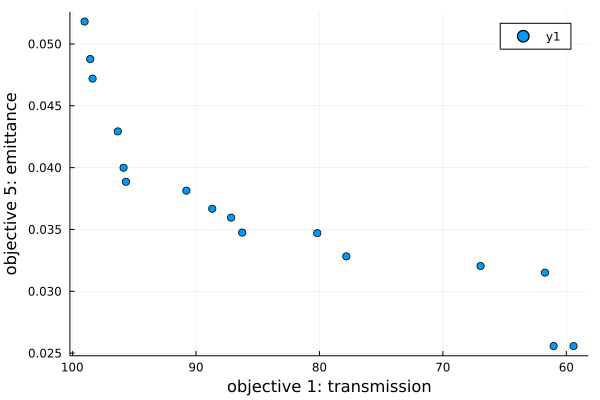

In [17]:
scatter(obj1, obj5; xlabel="objective 1: transmission", ylabel="objective 5: emittance")
xflip!(true)

### Final optimization
- Maximize transmission (< 95%)
- Output energy should be 70 KeV (0.070 MeV)
- Minimize RFQ length
- Minimize longitudinal emittance
- Minimize transverse emittance

In [18]:
function objective3(x_vec)
    y = predict(x_vec)
    target_energy_scaled = transform(y_scalers["OBJ2"], 0.070)[1]
    [-y[1], (y[2] - target_energy_scaled)^2, y[3], y[4], y[5]]
end

objective3 (generic function with 1 method)

In [19]:
x3s = [sample for sample in initial_samples];
x3s = unique(x3s)
y3s = objective3.(x3s);

In [20]:
if length(x3s) != length(unique(x3s))
    print("Duplicate entries in x3")
end
if length(x3s) != length(y3s)
    print("Dimension mismatch between x3 and y")
end
radial_basis_ego_3 = RadialBasis(x3s, y3s, lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [21]:
pareto_set_3, pareto_front_3 = surrogate_optimize(
    objective3, SMB(), lower_bound, upper_bound, radial_basis_ego_3, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [22]:
obj1_3 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front_3];
dE_3 = [item[2] for item in pareto_front_3];
obj3_3 = [inverse_transform(y_scalers["OBJ3"], item[3])[1] for item in pareto_front_3];
obj4_3 = [inverse_transform(y_scalers["OBJ4"], item[4])[1] for item in pareto_front_3];
obj5_3 = [inverse_transform(y_scalers["OBJ5"], item[5])[1] for item in pareto_front_3];

In [23]:
function plot_pairwise_scatter(vec1, vec2, vec1label, vec2label, indexes)
    scatter(
        vec1, vec2;
        xlabel=vec1label, ylabel=vec2label, marker_z=indexes, color=:brg, legend=false, colorbar=true
    )
end

plot_pairwise_scatter (generic function with 1 method)

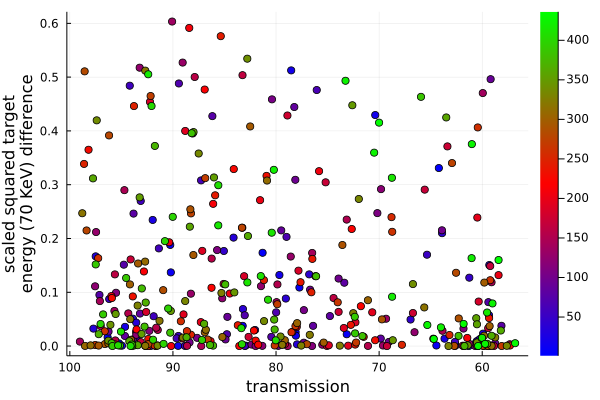

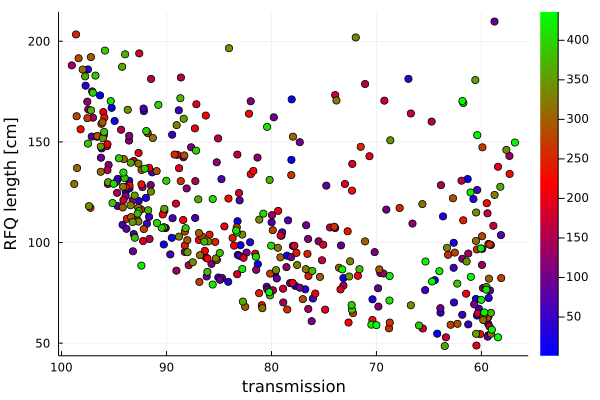

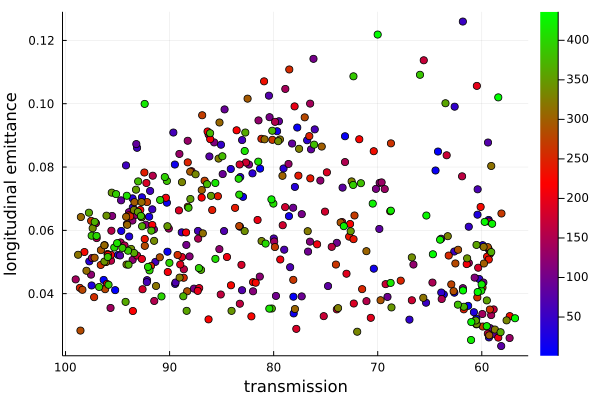

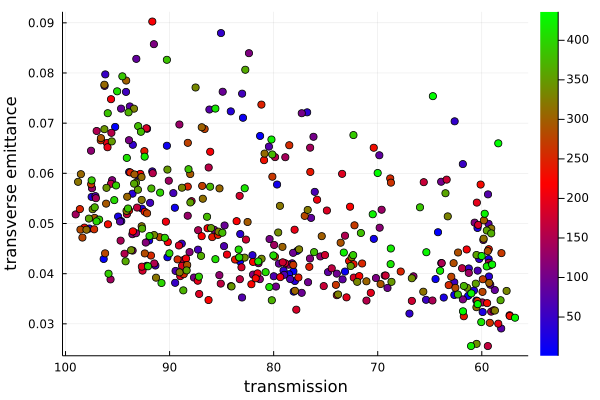

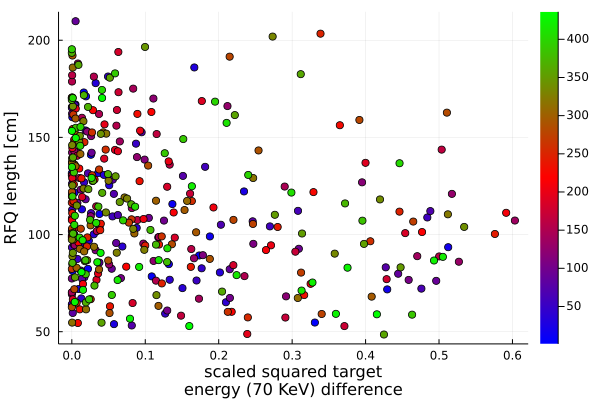

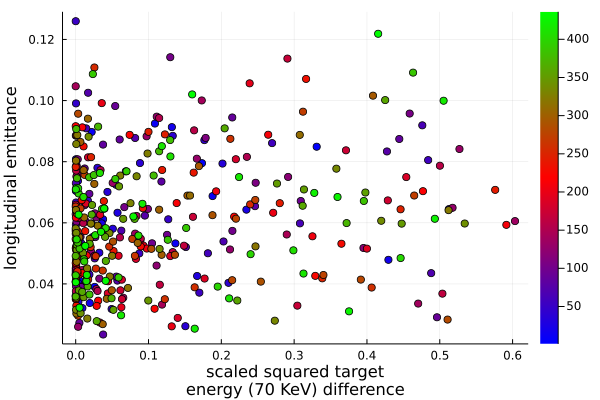

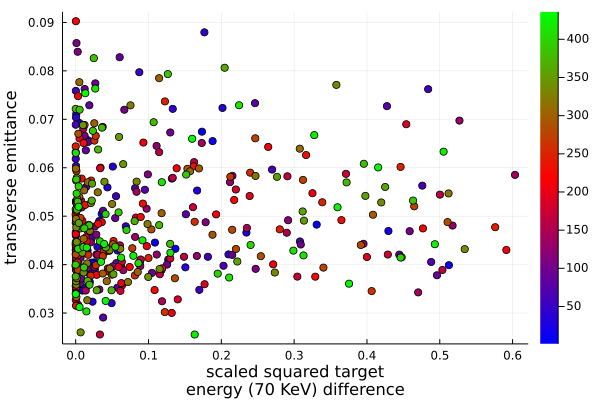

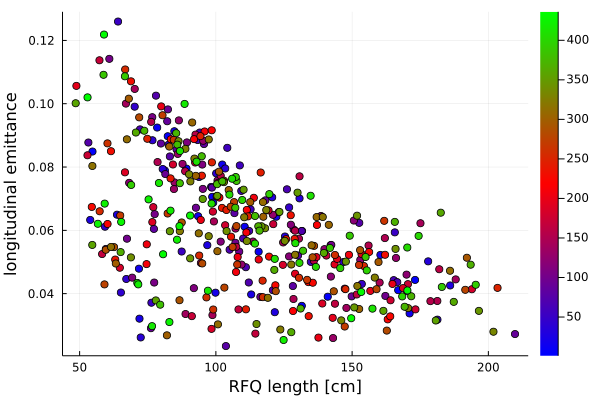

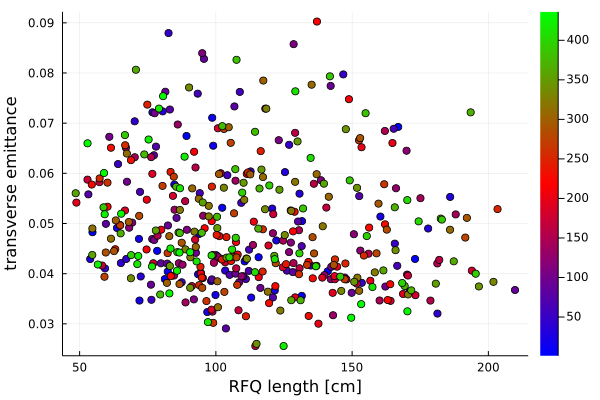

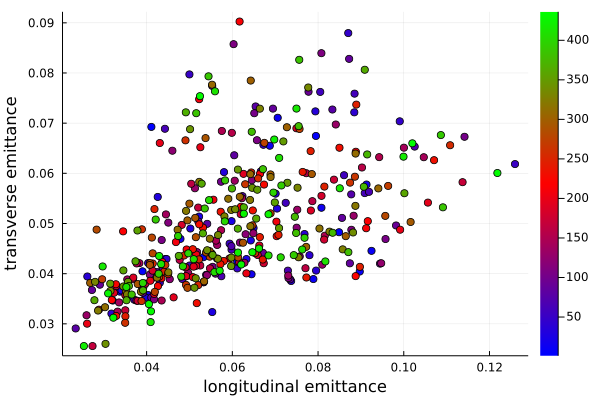

In [24]:
unscaled_pareto_front_3 = [obj1_3, dE_3, obj3_3, obj4_3, obj5_3]
labels = [
    "transmission",
    "scaled squared target\nenergy (70 KeV) difference",
    "RFQ length [cm]",
    "longitudinal emittance",
    "transverse emittance"
]
indexes = [i for i in 1:length(pareto_front_3)]

for i in 1:5
    for j in 1:5
        if i < j
            p = plot_pairwise_scatter(
                unscaled_pareto_front_3[i], unscaled_pareto_front_3[j], labels[i], labels[j], indexes
            )
            if i == 1
                xflip!(true)
            end
            display(p)
        end
    end
end

In [25]:
emit_cutoff = 0.05

long_emit_mask = obj4_3 .< emit_cutoff; trans_emit_mask = obj5_3 .< emit_cutoff;

sum(long_emit_mask .& trans_emit_mask)

130

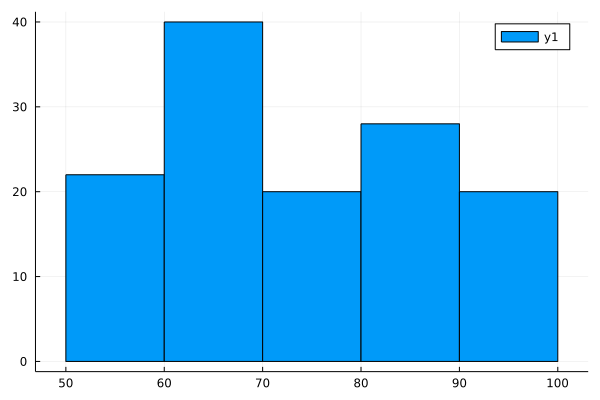

In [26]:
low_emit_transmission_values = obj1_3[long_emit_mask .& trans_emit_mask];

histogram(low_emit_transmission_values)

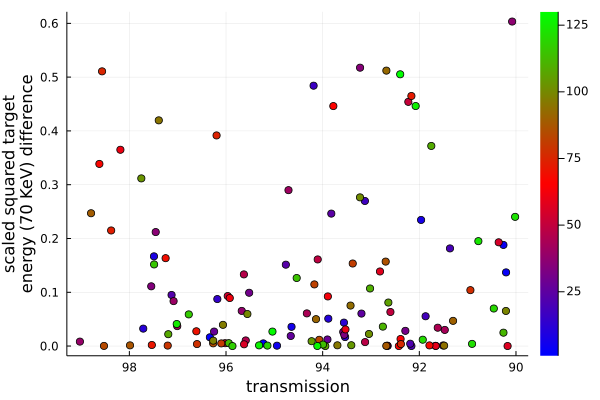

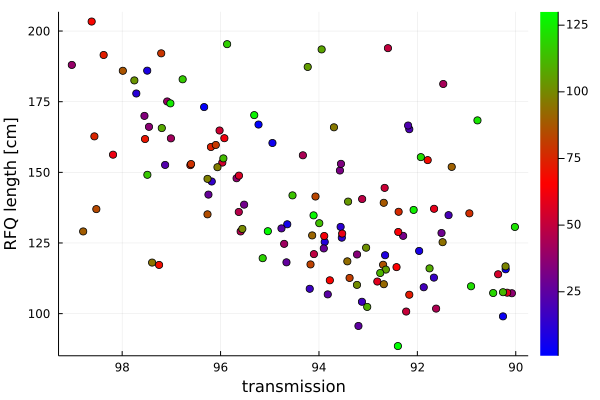

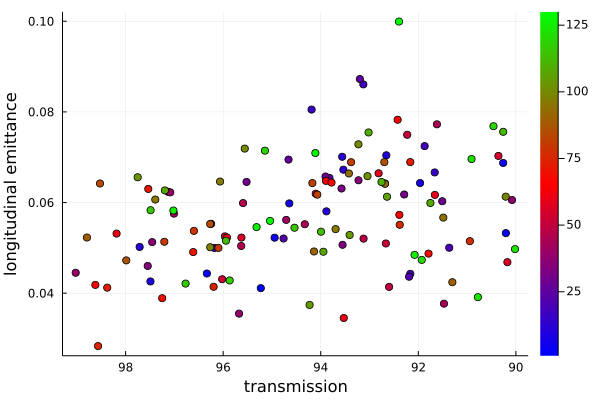

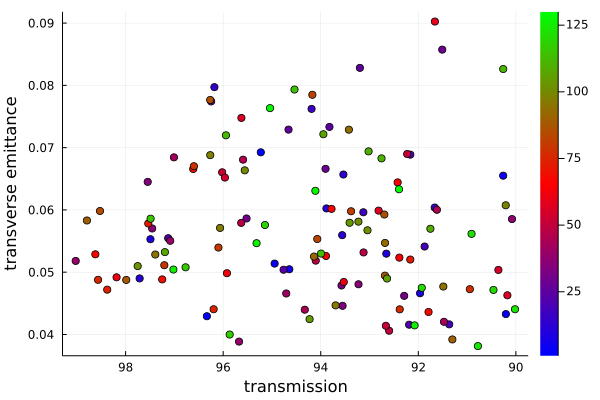

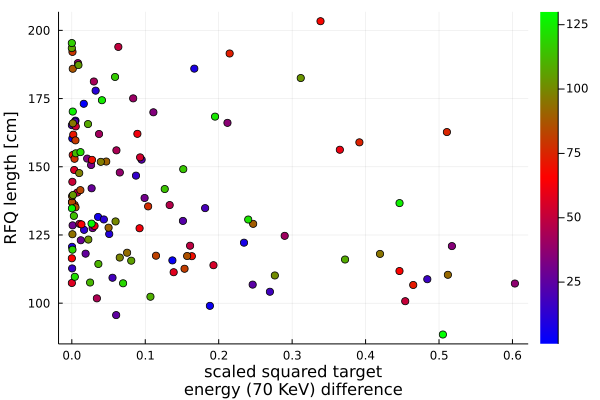

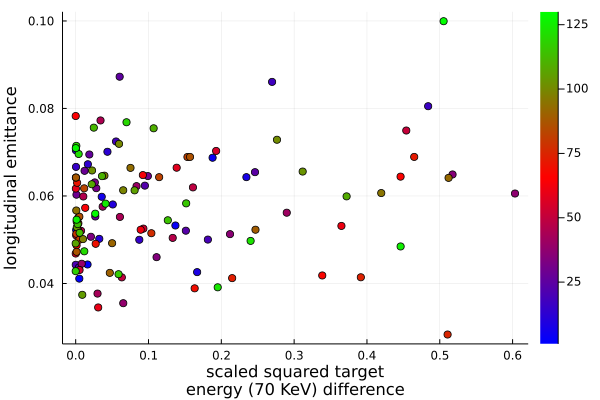

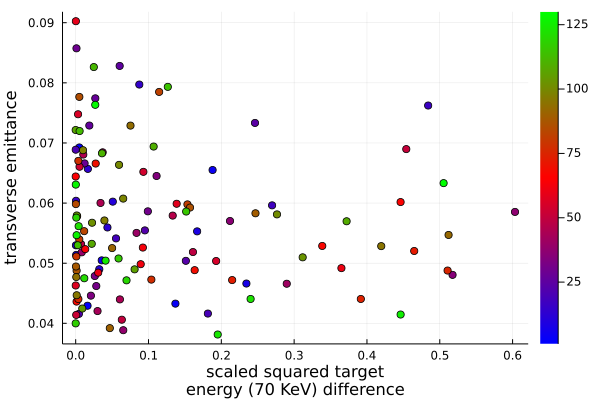

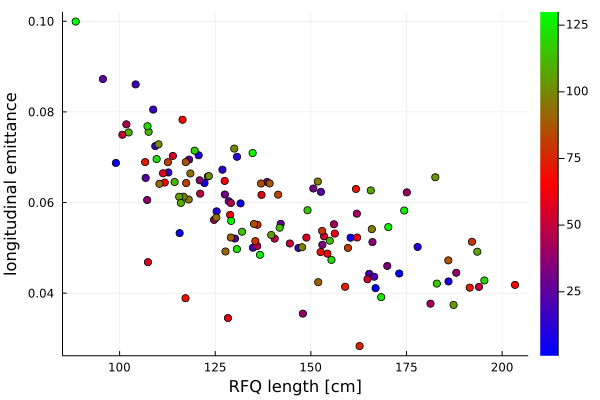

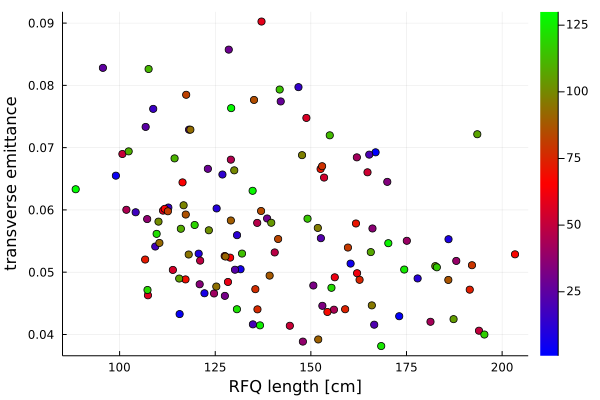

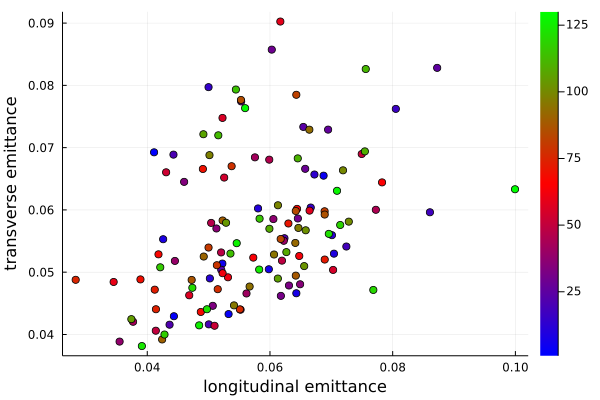

In [27]:
# let's only plot points that have transmission of at least 90%
transmission_mask = obj1_3 .> 90

masked_pareto_front_3 = [
    obj1_3[transmission_mask],
    dE_3[transmission_mask],
    obj3_3[transmission_mask],
    obj4_3[transmission_mask],
    obj5_3[transmission_mask],
]
masked_indexes = [i for i in 1:sum(transmission_mask)]

for i in 1:5
    for j in 1:5
        if i < j
            p = plot_pairwise_scatter(
                masked_pareto_front_3[i], masked_pareto_front_3[j], labels[i], labels[j], masked_indexes
            )
            if i == 1
                xflip!(true)
            end
            display(p)
        end
    end
end

### 3-way optimization
1. max transmission
2. minimize long emit
3. minimize transverse emit

In [28]:
function objective4(x_vec)
    y = predict(x_vec)
    [-y[1], y[4], y[5]]
end

objective4 (generic function with 1 method)

In [29]:
x4s = [sample for sample in initial_samples];
x4s = unique(x4s)
y4s = objective4.(x4s);

In [30]:
if length(x4s) != length(unique(x4s))
    print("Duplicate entries in x4")
end
if length(x4s) != length(y4s)
    print("Dimension mismatch between x4 and y")
end
radial_basis_ego_4 = RadialBasis(x4s, y4s, lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{NTuple{14, Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Float64, Bool}) (generic function with 1 method)

In [31]:
pareto_set_4, pareto_front_4 = surrogate_optimize(
    objective4, SMB(), lower_bound, upper_bound, radial_basis_ego_4, SobolSample();
    maxiters = 100, n_new_look = 100
);

In [32]:
obj1_4 = [inverse_transform(y_scalers["OBJ1"], -item[1])[1] for item in pareto_front_4];
# dE_4 = [item[2] for item in pareto_front_4];
# obj3_4 = [inverse_transform(y_scalers["OBJ3"], item[3])[1] for item in pareto_front_4];
obj4_4 = [inverse_transform(y_scalers["OBJ4"], item[2])[1] for item in pareto_front_4];
obj5_4 = [inverse_transform(y_scalers["OBJ5"], item[3])[1] for item in pareto_front_4];

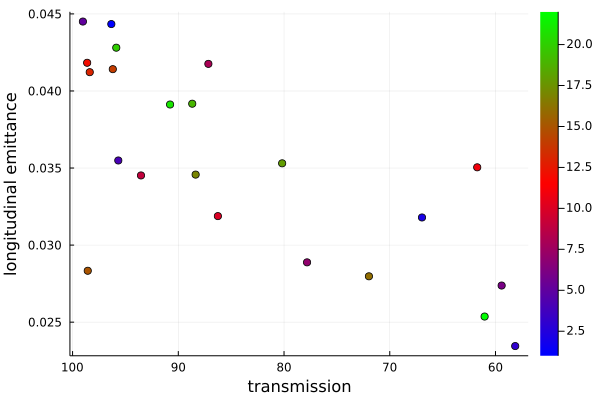

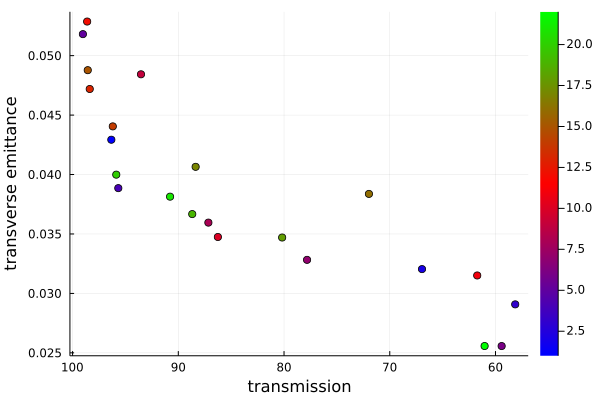

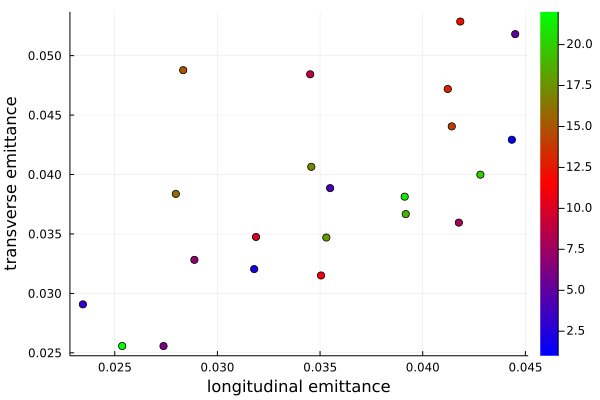

In [33]:
unscaled_pareto_front_4 = [obj1_4, obj4_4, obj5_4]
labels = [
    "transmission",
    "longitudinal emittance",
    "transverse emittance"
]
indexes = [i for i in 1:length(pareto_front_4)]

for i in 1:3
    for j in 1:3
        if i < j
            p = plot_pairwise_scatter(
                unscaled_pareto_front_4[i], unscaled_pareto_front_4[j], labels[i], labels[j], indexes
            )
            if i == 1
                xflip!(true)
            end
            display(p)
        end
    end
end

In [34]:
transmission_mask_4 = obj1_4 .> 90;

high_transmission_points_4 = pareto_set_4[transmission_mask_4]

10-element Vector{Any}:
 (0.255859375, -0.248046875, -0.841796875, -0.267578125, 0.666015625, -0.119140625, 0.478515625, 0.568359375, -0.494140625, 0.080078125, 0.705078125, -0.017578125, -0.884765625, 0.466796875)
 (-0.630859375, -0.111328125, -0.970703125, 0.439453125, 0.599609375, -0.365234375, 0.146484375, 0.353515625, -0.755859375, 0.787109375, 0.662109375, -0.248046875, -0.716796875, 0.681640625)
 (0.119140625, -0.361328125, 0.779296875, -0.810546875, -0.150390625, 0.384765625, 0.396484375, 0.103515625, -0.505859375, 0.037109375, 0.912109375, 0.501953125, -0.966796875, -0.568359375)
 (-0.4033203125, 0.7841796875, -0.9482421875, -0.6201171875, 0.8330078125, -0.0927734375, -0.6103515625, -0.0439453125, -0.8876953125, 0.8115234375, 0.9248046875, -0.2509765625, -0.9931640625, -0.1669921875)
 (-0.6689453125, 0.7685546875, -0.0888671875, -0.9482421875, -0.6513671875, -0.7021484375, 0.9677734375, 0.3466796875, -0.3720703125, -0.2978515625, 0.7841796875, -0.9541015625, -0.8837890625, -0.